In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.regularizers import l2

In [7]:
# rawgithub에서 당뇨병 데이터 로드
url = "https://raw.githubusercontent.com/MyungKyuYi/AI-class/main/diabetes.csv"
df = pd.read_csv(url)

In [15]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [19]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [21]:
# 데이터 전처리
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
# 특성 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [25]:
# 1. 머신러닝 모델 (Random Forest)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_predictions = rf_model.predict(X_test_scaled)
rf_accuracy = accuracy_score(y_test, rf_predictions)

print("Random Forest 모델 성능:")
print(f"정확도: {rf_accuracy:.4f}")
print(classification_report(y_test, rf_predictions))

Random Forest 모델 성능:
정확도: 0.7208
              precision    recall  f1-score   support

           0       0.79      0.78      0.78        99
           1       0.61      0.62      0.61        55

    accuracy                           0.72       154
   macro avg       0.70      0.70      0.70       154
weighted avg       0.72      0.72      0.72       154



In [45]:
def create_model():
    inputs = tf.keras.Input(shape=(8,))
    x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(0.01))(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [47]:
# K-fold 교차 검증
n_splits = 5
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
cv_scores = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_scaled)):
    print(f"\nFold {fold+1}/{n_splits}")
    
    X_train_fold, X_val_fold = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    model = create_model()
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10, restore_best_weights=True
    )
    
    history = model.fit(
        X_train_fold, y_train_fold,
        epochs=100,
        batch_size=32,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=[early_stopping],
        verbose=0
    )
    
    scores = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f"Fold {fold+1} - Validation Accuracy: {scores[1]:.4f}")
    cv_scores.append(scores[1])

print(f"\nMean cross-validation accuracy: {np.mean(cv_scores):.4f}")


Fold 1/5
Fold 1 - Validation Accuracy: 0.7561

Fold 2/5
Fold 2 - Validation Accuracy: 0.7886

Fold 3/5
Fold 3 - Validation Accuracy: 0.7561

Fold 4/5
Fold 4 - Validation Accuracy: 0.7724

Fold 5/5
Fold 5 - Validation Accuracy: 0.7705

Mean cross-validation accuracy: 0.7687


In [48]:
# 최종 모델 훈련
final_model = create_model()
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)

history = final_model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5322 - loss: 1.5099 - val_accuracy: 0.7398 - val_loss: 1.1705
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5775 - loss: 1.3559 - val_accuracy: 0.7480 - val_loss: 1.1269
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6397 - loss: 1.2874 - val_accuracy: 0.7317 - val_loss: 1.0947
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6921 - loss: 1.1758 - val_accuracy: 0.7236 - val_loss: 1.0633
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6739 - loss: 1.1492 - val_accuracy: 0.7480 - val_loss: 1.0327
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6950 - loss: 1.1029 - val_accuracy: 0.7480 - val_loss: 1.0086
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7011 - loss: 1.1178 - val_accuracy: 0.7642 - val_loss: 0.9893
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7376 - loss: 1.0210 - val_accuracy: 0.7561 - 

In [51]:
# 모델 평가
test_loss, test_accuracy = final_model.evaluate(X_test_scaled, y_test)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

y_pred = final_model.predict(X_test_scaled)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7251 - loss: 0.6162

Test Accuracy: 0.7273
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.80      0.79        99
           1       0.62      0.60      0.61        55

    accuracy                           0.73       154
   macro avg       0.70      0.70      0.70       154
weighted avg       0.73      0.73      0.73       154



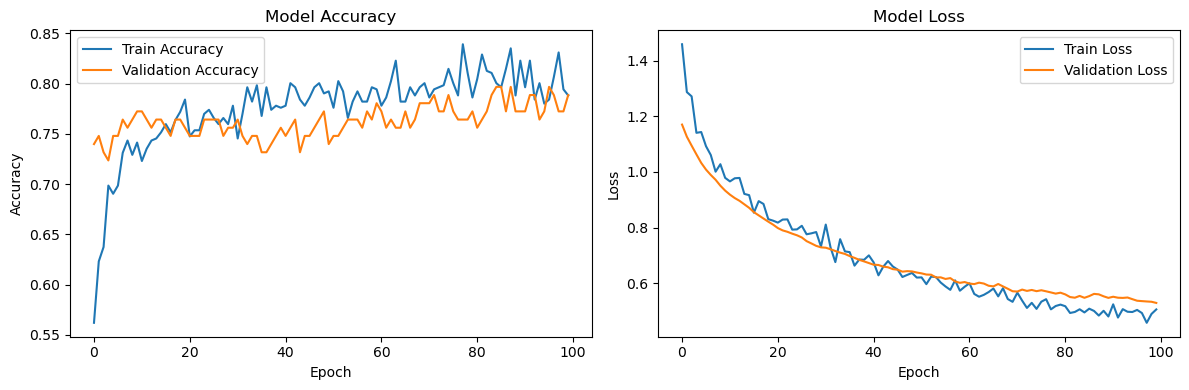

In [53]:
# 학습 곡선 그리기
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [55]:
# 모델 성능 비교
print("\n모델 성능 비교:")
print(f"랜덤 포레스트 정확도: {rf_accuracy:.4f}")
print(f"딥러닝 모델 정확도: {dl_accuracy:.4f}")


모델 성능 비교:
랜덤 포레스트 정확도: 0.7208
딥러닝 모델 정확도: 0.7468
